In [1]:
!pip install pytorchvideo evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.wh

In [3]:
import huggingface_hub
import tarfile
import transformers
import pytorchvideo.data
import pytorchvideo.transforms
import torchvision.transforms
import evaluate
import torch
import numpy as np
import imageio
import IPython.display
import matplotlib.pyplot as plt

In [4]:
file_path = huggingface_hub.hf_hub_download(
    repo_id="sayakpaul/ucf101-subset",
    filename="UCF101_subset.tar.gz",
    repo_type="dataset"
)
with tarfile.open(file_path) as t:
    t.extractall(".")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


UCF101_subset.tar.gz:   0%|          | 0.00/171M [00:00<?, ?B/s]

# 동영상자료의 이해

In [9]:
video_path = "UCF101_subset/test/BenchPress/v_BenchPress_g05_c02.avi"
video = pytorchvideo.data.encoded_video.EncodedVideo.from_path(video_path).get_clip(0, float('inf'))['video']

In [10]:
import huggingface_hub
import tarfile
import transformers
import pytorchvideo.data
import pytorchvideo.transforms
import torchvision.transforms
import evaluate
import torch
import numpy as np
# import imageio
# import IPython.display
# import matplotlib.pyplot as plt
#---#
## Step1
file_path = huggingface_hub.hf_hub_download(
    repo_id="sayakpaul/ucf101-subset",
    filename="UCF101_subset.tar.gz",
    repo_type="dataset"
)
with tarfile.open(file_path) as t:
    t.extractall(".")
train_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("random", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
            key="video",
            transform=torchvision.transforms.Compose(
                [
                    pytorchvideo.transforms.UniformTemporalSubsample(16),
                    torchvision.transforms.Lambda(lambda x: x / 255.0),
                    pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    pytorchvideo.transforms.RandomShortSideScale(min_size=256, max_size=320),
                    torchvision.transforms.RandomCrop((224,224)),
                    torchvision.transforms.RandomHorizontalFlip(p=0.5),
                ]
            ),
        )
)
val_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/val',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
            key="video",
            transform=torchvision.transforms.Compose(
                [
                    pytorchvideo.transforms.UniformTemporalSubsample(16),
                    torchvision.transforms.Lambda(lambda x: x / 255.0),
                    pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    torchvision.transforms.Resize((224,224))
                ]
            ),
        )
)
test_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/test',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
            key="video",
            transform=torchvision.transforms.Compose(
                [
                    pytorchvideo.transforms.UniformTemporalSubsample(16),
                    torchvision.transforms.Lambda(lambda x: x / 255.0),
                    pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    torchvision.transforms.Resize((224,224))
                ]
            ),
        )
)
## Step2
id2label = {
    0: 'ApplyEyeMakeup',
    1: 'Archery',
    2: 'BalanceBeam',
    3: 'BaseballPitch',
    4: 'BasketballDunk',
    5: 'ApplyLipstick',
    6: 'BabyCrawling',
    7: 'BandMarching',
    8: 'Basketball',
    9: 'BenchPress'
}
label2id = {
    'ApplyEyeMakeup': 0,
    'Archery': 1,
    'BalanceBeam': 2,
    'BaseballPitch': 3,
    'BasketballDunk': 4,
    'ApplyLipstick': 5,
    'BabyCrawling': 6,
    'BandMarching': 7,
    'Basketball': 8,
    'BenchPress': 9
}
model = transformers.VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Step3
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)
def collate_fn(examples): # examples 는 [Dict, Dict, ...]
    tsr_ntchw = torch.stack([example['video'].permute(1,0,2,3) for example in examples])
    tsrlb_n = torch.tensor([example['label'] for example in examples])
    return dict(pixel_values=tsr_ntchw,labels=tsrlb_n)
args = transformers.TrainingArguments(
    '영상분류학습된모델',
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // 8) * 4,
    report_to="none"
)
image_processor = transformers.VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base")
trainer = transformers.Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

max_steps is given, it will override any value given in num_train_epochs


Epoch,Training Loss,Validation Loss,Accuracy
0,2.136800,1.904736,0.371429
1,1.106900,0.991131,0.628571
2,0.434800,0.582366,0.785714
3,0.276300,0.456094,0.900000


In [13]:
train_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("random", 10),
    decode_audio = False,
#    transform = train_transform,
)

In [17]:
video_path = "UCF101_subset/test/BenchPress/v_BenchPress_g05_c02.avi"
video = pytorchvideo.data.encoded_video.EncodedVideo.from_path(video_path).get_clip(0, float('inf'))['video']

In [18]:
video

tensor([[[[161., 161., 161.,  ..., 157., 157., 157.],
          [160., 160., 160.,  ..., 156., 156., 156.],
          [156., 156., 156.,  ..., 155., 155., 155.],
          ...,
          [157., 157., 157.,  ..., 116., 116., 116.],
          [157., 157., 157.,  ..., 116., 116., 116.],
          [157., 157., 157.,  ..., 116., 116., 116.]],

         [[160., 160., 160.,  ..., 157., 157., 157.],
          [156., 156., 156.,  ..., 156., 156., 156.],
          [151., 151., 151.,  ..., 155., 155., 155.],
          ...,
          [157., 157., 157.,  ..., 116., 116., 116.],
          [157., 157., 157.,  ..., 116., 116., 116.],
          [157., 157., 157.,  ..., 116., 116., 116.]],

         [[160., 160., 160.,  ..., 157., 157., 157.],
          [156., 156., 156.,  ..., 156., 156., 156.],
          [151., 151., 151.,  ..., 155., 155., 155.],
          ...,
          [157., 157., 157.,  ..., 116., 116., 116.],
          [157., 157., 157.,  ..., 116., 116., 116.],
          [157., 157., 157.,  ...

In [38]:
video.shape

torch.Size([3, 67, 240, 320])

In [22]:
video_thwc = video.permute(1,2,3,0)
video_thwc.shape # 사진 프레임이 72개 들어있음

torch.Size([67, 240, 320, 3])

In [23]:
video_thwc = video.permute(1,2,3,0)
video_thwc.shape

torch.Size([67, 240, 320, 3])

In [39]:
def _display_gif(video):
    video_thwc = video.permute(1,2,3,0)
    frames = [frame.numpy().astype('uint8') for frame in video]
    imageio.mimsave("sample.gif",frames)
    return IPython.display.Image("sample.gif")

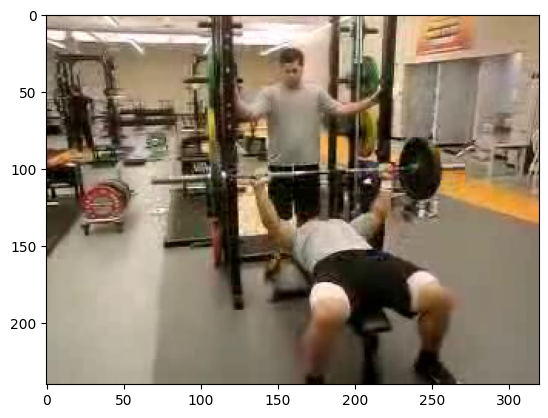

In [55]:
plt.imshow(video_thwc[-1].numpy().astype('uint8')) # 동영상을 사진 프레임마다 자른 모음집의 n번째 사진

In [56]:
video_cls = transformers.pipeline(
    task="video-classification",
    model="영상분류학습된모델/checkpoint-148",
)
video_cls("UCF101_subset/test/BenchPress/v_BenchPress_g05_c02.avi")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.8567178249359131, 'label': 'BenchPress'},
 {'score': 0.05527196452021599, 'label': 'BalanceBeam'},
 {'score': 0.02230919525027275, 'label': 'BandMarching'},
 {'score': 0.012038836255669594, 'label': 'BabyCrawling'},
 {'score': 0.011314979754388332, 'label': 'ApplyLipstick'}]

In [ ]:
sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [60]:
def _display_gif(video_thwc):
    video_thwc = video_thwc.permute(1,2,3,0)
    frames = [frame.numpy().astype('uint8') for frame in video]
    imageio.mimsave("sample.gif",frames)
    return IPython.display.Image("sample.gif")

In [62]:
_display_gif(next(video_thwc)['video'])

TypeError: 'Tensor' object is not an iterator

In [46]:
transform = pytorchvideo.transforms.ApplyTransformToKey(
        key="video",
        transform=torchvision.transforms.Compose(
            [
                pytorchvideo.transforms.UniformTemporalSubsample(4),
                torchvision.transforms.Lambda(lambda x: x / 255.0), # tensor 값을 255로 나눔
                pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # mean, std. 255로 나눈 애들을 mean과 std로 적용되어 표준화됨. 마이너스값도 있으므로 아직까지 우리가 생각한 이미지로 안 나옴
                torchvision.transforms.Resize((112,112))
            ]
        )
)

## (3)

In [ ]:
def _display_gif(video_cthw):
    video_thwc = video_cthw.permute(1,2,3,0)
    frames = [frame.numpy().astype('uint8') for frame in video_thwc]
    imageio.mimsave("sample.gif",frames)
    return IPython.display.Image("sample.gif")

In [ ]:
_display_gif(next(_train_dataset)['video'])

## (4)

In [ ]:
clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 4)

In [ ]:
val_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/val',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 4),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
            key="video",
            transform=torchvision.transforms.Compose(
                [
                    pytorchvideo.transforms.UniformTemporalSubsample(16),
                    torchvision.transforms.Lambda(lambda x: x / 255.0),
                    pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    torchvision.transforms.Resize((224,224))
                ]
            ),
        )
)

# ucf101

In [47]:
label2id = {
    'ApplyEyeMakeup': 0,
    'ApplyLipstick': 1,
    'Archery': 2,
    'BabyCrawling': 3,
    'BalanceBeam': 4,
    'BandMarching': 5,
    'BaseballPitch': 6,
    'Basketball': 7,
    'BasketballDunk': 8,
    'BenchPress': 9
}
id2label = {
    0: 'ApplyEyeMakeup',
    1: 'ApplyLipstick',
    2: 'Archery',
    3: 'BabyCrawling',
    4: 'BalanceBeam',
    5: 'BandMarching',
    6: 'BaseballPitch',
    7: 'Basketball',
    8: 'BasketballDunk',
    9: 'BenchPress'
}
config = transformers.VideoMAEConfig.from_pretrained("MCG-NJU/videomae-base")
config.num_frames = 4  # 프레임 수를 4로 조정
config.label2id = label2id
config.id2label = id2label
config.image_size = 112   # 이미지 크기를 112x112로 조정

# 설정된 config로 모델 선언
model = transformers.VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base",
    config=config,
    ignore_mismatched_sizes=True  # 가중치 크기 불일치 무시
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
# clip_sampler
pytorchvideo.data.make_clip_sampler("random", 3),
# transform
pytorchvideo.transforms.UniformTemporalSubsample(4),
torchvision.transforms.Lambda(lambda x: x / 255.0),
pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
torchvision.transforms.Resize((112,112))

Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=True)

In [65]:
def collate_fn(examples): # examples 는 [Dict, Dict, ...]
    tsr_ntchw = torch.stack([example['video'].permute(1,0,2,3) for example in examples])
    tsrlb_n = torch.tensor([example['label'] for example in examples])
    return dict(pixel_values=tsr_ntchw,labels=tsrlb_n)

In [66]:
transformers.TrainingArguments(
    '영상분류학습된모델',
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // 8) * 4,
    report_to="none"
)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
eval_use_gather_object=False,
evaluation_strategy=None,
fp1

In [63]:
image_processor = transformers.VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base")
trainer = transformers.Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


In [69]:
model(torch.stack([example['video'].permute(1,0,2,3) for example in examples],axis=0))

IndexError: too many indices for tensor of dimension 4

배치 사이즈 = 8

In [ ]:
train_results = trainer.train()